In [35]:
import numpy as np
import pandas as pd
import json
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import pickle

In [36]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Bishal
[nltk_data]     Roy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Bishal
[nltk_data]     Roy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Bishal
[nltk_data]     Roy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
intents = {
    "greeting": {
        "patterns": [
            "hello", "hi", "hey", "good morning", "good afternoon", 
            "good evening", "hi there", "hello there", "greetings", 
            "what's up", "how are you", "nice to meet you", "howdy", 
            "yo", "hey there"
        ],
        "responses": [
            "Hello! How can I assist you today?",
            "Hi there! What would you like to chat about?",
            "Greetings! I'm here to help with your questions.",
            "Hey! How can I assist you today?",
            "Good to see you! What can I do for you?",
            "Hello! What brings you here today?",
            "Howdy! Ready to assist you with anything.",
            "Greetings! Let's chat about something interesting.",
            "Hello! I'm excited to help you with any questions.",
            "Hi! How can I make your day easier?"
        ]
    },
    "who_are_you": {
        "patterns": [
            "who are you", "what is RoY", "tell me about yourself", 
            "what do you do", "what's your purpose", "what is your function"
        ],
        "responses": [
            "I am RoY, your AI assistant created by OpenAI to assist with a wide variety of tasks.",
            "I’m RoY, an AI here to provide information, solve problems, and make your tasks easier.",
            "My name is RoY, and I'm designed to help you with anything you need, from answering questions to providing detailed explanations.",
            "I’m RoY, an advanced AI assistant capable of helping with everything from coding to creative writing.",
            "I’m here as RoY, your personal assistant designed to provide solutions to your questions and challenges.",
            "I’m RoY, a conversational AI here to help you with tasks and offer insightful solutions.",
            "My name is RoY, and I am an AI assistant trained to help you solve problems and make your tasks easier.",
            "I am RoY, created to assist you with anything from casual chats to detailed explanations in various fields.",
            "I’m RoY, and I’m here to offer you help in any way I can. Let’s tackle your questions together!",
            "I’m RoY, your friendly assistant designed to provide quick, accurate answers and assist with any task you have."
        ]
    },
    "help": {
        "patterns": [
            "I need help", "can you help me", "help me out", "can you assist me", 
            "I need assistance", "help please", "I have a problem"
        ],
        "responses": [
            "Of course! What do you need help with?",
            "I’m here to help! Just let me know what you need assistance with.",
            "Tell me your problem, and I’ll do my best to help you out.",
            "Sure, how can I assist you today?",
            "I'm ready to assist you. What do you need help with?",
            "I’m happy to help! Just describe the issue, and I’ll do my best to provide a solution.",
            "I’ve got your back! What can I help you with?",
            "I’m here to make things easier for you. Let me know how I can assist.",
            "Don’t worry, I’m here to help! What’s going on?",
            "Sure thing! What’s the problem? I’ll do my best to help."
        ]
    },
    "small_talk": {
        "patterns": [
            "how are you", "how's it going", "what's up", "how's your day", 
            "tell me something interesting", "what are you doing", "what's new"
        ],
        "responses": [
            "I'm just here, ready to help you with anything! How about you?",
            "I'm doing great, thanks for asking! How about you?",
            "Everything’s going smoothly. How’s your day going?",
            "I'm all set to help you with anything. What's up with you?",
            "Just here, ready for some great conversation. What's new with you?",
            "I’m doing fine, thanks! What about you?",
            "I’m here and ready to assist you. How are things on your end?",
            "Not much, just waiting for your next question. What’s on your mind?",
            "Same old, same old! What about you?",
            "I’m doing great, thanks for asking! How’s everything going with you?"
        ]
    },
    "fun": {
        "patterns": [
            "tell me a joke", "tell me something fun", "make me laugh", "tell me a funny story",
            "do you know any jokes", "can you entertain me", "tell me something interesting"
        ],
        "responses": [
            "Why don’t skeletons fight each other? They don’t have the guts!",
            "I told my computer I needed a break... now it won’t stop sending me Kit-Kats!",
            "Why don’t scientists trust atoms? Because they make up everything!",
            "Knock knock! Who’s there? Lettuce. Lettuce who? Lettuce in, it’s freezing out here!",
            "Why did the scarecrow win an award? Because he was outstanding in his field!",
            "I once tried to start a band called 1023MB… we never made it to a gig!",
            "What’s orange and sounds like a parrot? A carrot!",
            "Why did the chicken join a band? Because it had the drumsticks!",
            "I used to play piano by ear, but now I use my hands!",
            "Why don’t programmers like nature? It has too many bugs!"
        ]
    },
    "data_science": {
        "patterns": [
            "what is data science", "explain data science", "data science process",
            "data science lifecycle", "data analysis steps", "statistical analysis",
            "data visualization", "big data analytics", "data mining",
            "predictive analytics", "data science tools", "data science applications"
        ],
        "responses": [
            "Data Science is a multidisciplinary field that combines statistics, programming, and domain expertise to extract knowledge from data.",
            "The Data Science process includes collecting data, cleaning it, performing exploratory data analysis (EDA), and building predictive models.",
            "Data Science applications include business intelligence, marketing analysis, fraud detection, and even scientific research.",
            "Tools commonly used in Data Science include Python, R, SQL, and platforms like TensorFlow and PyTorch.",
            "The life cycle of Data Science involves understanding the problem, collecting and cleaning data, modeling, and deploying solutions.",
            "Data Science involves using statistical and computational techniques to interpret complex data and derive actionable insights.",
            "In Data Science, we use visualization techniques such as graphs, charts, and dashboards to make data easier to interpret.",
            "Big Data analytics refers to analyzing and extracting valuable insights from large and complex datasets.",
            "Data Science plays a critical role in decision-making processes, helping businesses optimize operations and predict future trends.",
            "Predictive analytics is used in Data Science to forecast future trends based on historical data, commonly used in finance and marketing."
        ]
    },
    "machine_learning": {
        "patterns": [
            "what is machine learning", "explain machine learning", "ml basics", 
            "how does ml work", "types of machine learning", "supervised learning", 
            "unsupervised learning", "what is supervised learning", "ml algorithms",
            "popular ml algorithms", "machine learning applications", "where is ml used"
        ],
        "responses": [
            "Machine Learning (ML) is a subset of AI that allows systems to automatically improve from experience without being explicitly programmed.",
            "ML algorithms learn from data by finding patterns, and they can be used in a variety of applications, from image recognition to natural language processing.",
            "The most common types of ML are Supervised Learning, where models are trained with labeled data, and Unsupervised Learning, where models find patterns in unlabeled data.",
            "Popular ML algorithms include Decision Trees, Random Forests, K-Nearest Neighbors, and Support Vector Machines.",
            "Supervised Learning is a type of machine learning where models are trained on labeled data to predict outcomes based on input features.",
            "Unsupervised Learning involves training models on data that is not labeled. It is used for clustering, anomaly detection, and dimensionality reduction.",
            "ML is used in a variety of applications such as recommendation systems (e.g., Netflix), fraud detection, and image classification.",
            "Machine Learning can be used in healthcare for predicting disease outcomes, in finance for detecting fraud, and in marketing for customer segmentation.",
            "Some of the key applications of machine learning include autonomous driving, voice assistants, and predictive analytics.",
            "In ML, feature engineering is the process of selecting the most relevant features for training models to improve their performance."
        ]
    },
    "deep_learning": {
        "patterns": [
            "what is deep learning", "explain deep learning", "dl basics", 
            "neural networks explanation", "how do neural networks work", 
            "deep learning vs machine learning", "dl applications", 
            "deep learning examples", "neural network architecture", "types of neural networks"
        ],
        "responses": [
            "Deep Learning is a subset of Machine Learning that uses neural networks with many layers to process data and make decisions.",
            "Neural networks in deep learning are designed to mimic the way the human brain processes information, allowing for complex pattern recognition.",
            "Deep Learning models are especially effective for tasks like image recognition, speech processing, and natural language understanding.",
            "Deep Learning differs from traditional ML in that it automates feature extraction, making it more powerful for tasks like image and speech recognition.",
            "Popular deep learning frameworks include TensorFlow, Keras, and PyTorch, which simplify building and training neural networks.",
            "Deep Learning excels at processing large amounts of unstructured data such as images, audio, and text.",
            "Some popular applications of deep learning include facial recognition, voice assistants, and self-driving cars.",
            "Convolutional Neural Networks (CNNs) are commonly used for image-related tasks, while Recurrent Neural Networks (RNNs) are often used for sequential data.",
            "Deep Learning has shown breakthroughs in areas such as medical image analysis, autonomous vehicles, and language translation.",
            "Deep Learning algorithms require a lot of data and computational power to train but often achieve higher accuracy than traditional machine learning models."
        ]
    },
    "neural_networks": {
        "patterns": [
            "what are neural networks", "how do neural networks work", 
            "neural network architecture", "types of neural networks",
            "neural network applications", "deep neural networks", "neural network layers"
        ],
        "responses": [
            "Neural Networks are a class of algorithms inspired by the structure of the human brain, used in both machine learning and deep learning.",
            "In a neural network, data is processed through layers of neurons, with each layer learning a particular aspect of the data.",
            "There are several types of neural networks, including feedforward networks, convolutional networks (CNNs), and recurrent networks (RNNs).",
            "A deep neural network refers to a network with many layers, which helps it learn more complex patterns and representations of data.",
            "Neural networks are used in a variety of applications, such as image recognition, speech processing, and natural language understanding.",
            "Each layer in a neural network performs different tasks, from initial feature extraction to final classification or prediction.",
            "Convolutional Neural Networks (CNNs) are particularly well-suited for image classification, while Recurrent Neural Networks (RNNs) excel with sequential data such as time series and text.",
            "Neural networks have been used for self-driving cars, medical diagnosis, and natural language processing tasks like translation and summarization.",
            "The power of neural networks lies in their ability to learn from large amounts of data, often outpacing traditional algorithms in accuracy.",
            "Feedforward neural networks are used for tasks like classification and regression, while other architectures, like GANs (Generative Adversarial Networks), are used for generative tasks."
        ]
    },
    "natural_language_processing": {
        "patterns": [
            "what is natural language processing", "explain NLP", "NLP techniques",
            "how does NLP work", "applications of NLP", "types of NLP",
            "NLP algorithms", "natural language understanding", "natural language generation"
        ],
        "responses": [
            "Natural Language Processing (NLP) is a field of AI that focuses on enabling machines to understand and generate human language.",
            "NLP involves several techniques such as tokenization, part-of-speech tagging, named entity recognition, and sentiment analysis.",
            "Some common NLP applications include chatbots, language translation, sentiment analysis, and text summarization.",
            "NLP works by processing text through various algorithms and models, often utilizing deep learning techniques like LSTM and Transformers.",
            "In NLP, Natural Language Understanding (NLU) involves comprehending meaning from text, while Natural Language Generation (NLG) is about generating meaningful text.",
            "NLP algorithms include methods like TF-IDF, Word2Vec, and BERT that convert text into numerical representations for analysis.",
            "Key areas of NLP include speech recognition, machine translation, text classification, and question-answering systems.",
            "NLP techniques are widely used in search engines, recommendation systems, and virtual assistants like Siri and Alexa.",
            "NLP aims to bridge the gap between human language and computer understanding, enabling machines to communicate with us more effectively.",
            "Some popular NLP models include GPT, BERT, and T5, which are based on Transformer architecture."
        ]
    },
    "generative_ai": {
        "patterns": [
            "what is generative AI", "explain generative AI", "how does generative AI work",
            "applications of generative AI", "types of generative AI", "examples of generative AI"
        ],
        "responses": [
            "Generative AI refers to AI models that can generate new content, such as images, text, music, or even video, based on learned patterns from data.",
            "Generative AI models use techniques like GANs (Generative Adversarial Networks), VAEs (Variational Autoencoders), and Transformers to create new data that mimics real-world examples.",
            "Some popular applications of Generative AI include image generation (e.g., DALL·E), text generation (e.g., GPT-3), and music creation (e.g., Jukedeck).",
            "Generative AI models are trained on large datasets and learn to create new, similar content. They can be fine-tuned for specific tasks, such as generating dialogue or art.",
            "Generative AI works by learning the distribution of data and then generating new instances from that learned distribution, providing novel, but realistic, outputs.",
            "Generative AI is used in creative industries, such as art and music, as well as practical fields like drug discovery and design optimization.",
            "Generative models like GPT-3 are capable of producing human-like text that can be used for writing, coding, and even engaging in meaningful conversations.",
            "Generative AI is increasingly applied in advertising and marketing, where personalized content is automatically generated for customer engagement.",
            "Some advanced forms of Generative AI include deepfakes and AI-generated art, which have sparked conversations about ethics and creativity.",
            "Generative AI enables not just content creation but also innovation in areas like autonomous design and creative problem-solving."
        ]
    },
    "lstm": {
        "patterns": [
            "what is LSTM", "explain LSTM", "how does LSTM work", "LSTM in NLP",
            "LSTM networks", "applications of LSTM", "LSTM vs RNN", "LSTM layers", "long short-term memory"
        ],
        "responses": [
            "LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) designed to handle sequential data with long-range dependencies.",
            "LSTM networks are particularly useful in tasks like speech recognition, machine translation, and time series forecasting, where data has temporal dependencies.",
            "Unlike traditional RNNs, LSTMs can maintain information across longer sequences and avoid issues like vanishing gradients, which makes them better suited for long-term memory.",
            "LSTM consists of memory cells that store information for long periods, and gates that control the flow of information into and out of these cells.",
            "Applications of LSTM in NLP include machine translation, speech-to-text, and sentiment analysis, where the model needs to remember context over long text spans.",
            "LSTMs are also used in video analysis and financial prediction, where sequences of events or trends need to be processed over time.",
            "Compared to traditional RNNs, LSTMs are more efficient in dealing with long-term dependencies in data, making them ideal for language models and time-series data.",
            "LSTM networks are a crucial part of many modern AI systems that require sequential decision-making and prediction, such as chatbots and text generation models.",
            "In LSTM, the gates (input, forget, and output) help decide how much information should be added, retained, or discarded at each step of the sequence.",
            "LSTMs are often used in conjunction with other deep learning techniques, such as attention mechanisms, to improve performance in tasks like machine translation and summarization."
        ]
    },
    "transformers": {
        "patterns": [
            "what is transformer model", "explain transformer architecture", "how does transformer work",
            "transformer in NLP", "transformer vs RNN", "applications of transformer models",
            "BERT transformer", "GPT transformer", "transformer layers"
        ],
        "responses": [
            "The Transformer is a deep learning architecture that relies on self-attention mechanisms, allowing it to process sequences of data more efficiently than traditional RNNs.",
            "Transformers have revolutionized NLP by enabling models to handle long-range dependencies in data without relying on sequential processing, which is typical in RNNs.",
            "In Transformers, self-attention allows the model to focus on different parts of a sentence simultaneously, making it highly parallelizable and efficient for large datasets.",
            "The key components of a Transformer model are the encoder and decoder layers, which are used to process input and output sequences.",
            "Some popular Transformer-based models include BERT (Bidirectional Encoder Representations from Transformers), GPT (Generative Pretrained Transformer), and T5 (Text-to-Text Transfer Transformer).",
            "Transformers are widely used in machine translation, text generation, question answering, and many other NLP tasks due to their flexibility and scalability.",
            "The transformer model's attention mechanism helps it determine the importance of each word in the input, improving its performance on tasks like language modeling.",
            "In NLP, Transformers have replaced traditional architectures like LSTMs and GRUs due to their superior performance on tasks like text classification and summarization.",
            "The key advantage of Transformer models is their ability to handle dependencies across long text sequences, making them ideal for tasks that involve context over large spans of text.",
            "Transformers are often pre-trained on large corpora and fine-tuned for specific tasks, making them adaptable and powerful for a wide range of applications."
        ]
    },
    "prompt_engineering": {
        "patterns": [
            "what is prompt engineering", "how to design a good prompt", "why is prompt engineering important",
            "prompt engineering techniques", "best practices for prompt engineering",
            "how does prompt engineering work", "prompt engineering for GPT", "why prompt design matters"
        ],
        "responses": [
            "Prompt engineering refers to the process of designing input prompts to guide AI models like GPT or BERT to produce desired responses.",
            "Good prompt engineering ensures that the AI model understands the task at hand and can generate relevant and accurate outputs.",
            "Prompt engineering techniques include being specific with instructions, using clear and concise language, and providing context that helps the model generate better results.",
            "With prompt engineering, we can influence the AI’s response to align with the intended task, whether it's answering a question, generating text, or solving a problem.",
            "For example, when using GPT, the way you phrase your prompt can drastically change the quality and relevance of the model’s output.",
            "Effective prompt engineering requires an understanding of the model's behavior and the types of inputs it works best with. It’s often an iterative process.",
            "Prompt engineering is crucial in natural language processing tasks, as it helps ensure that the model performs as expected without needing retraining.",
            "In the case of GPT, good prompt design involves asking clear and specific questions, including context if necessary, and ensuring the prompt aligns with the goal of the task.",
            "Some advanced techniques in prompt engineering include using prompt chaining, few-shot learning, and temperature tuning to control the creativity or randomness of outputs.",
            "Prompt engineering is becoming an essential skill for anyone working with advanced AI models, as it can significantly improve their performance on tasks."
        ]
    },
    "conversational_ai": {
        "patterns": [
            "what is conversational AI", "explain conversational AI", "how does conversational AI work",
            "applications of conversational AI", "chatbot technology", "dialogue systems", "virtual assistants",
            "conversational AI examples", "conversational AI vs traditional AI"
        ],
        "responses": [
            "Conversational AI refers to technologies that enable machines to engage in human-like dialogue, such as chatbots, virtual assistants, and automated customer support systems.",
            "Conversational AI systems utilize natural language processing (NLP), machine learning, and speech recognition to understand and respond to user queries in real-time.",
            "Some common examples of conversational AI include Siri, Alexa, Google Assistant, and chatbots used in customer service.",
            "Conversational AI is designed to simulate human conversation, improving customer interaction and automating tasks like scheduling, information retrieval, and support.",
            "A key component of conversational AI is Natural Language Understanding (NLU), which helps the system interpret user input and provide appropriate responses.",
            "With advancements in deep learning and NLP, conversational AI can now handle complex tasks, such as answering questions, conducting transactions, and providing recommendations.",
            "Conversational AI can be used in various industries, including healthcare, finance, retail, and customer service, to improve efficiency and user experience.",
            "The evolution of conversational AI includes using machine learning models like GPT-3 to generate human-like responses in text-based conversations.",
            "Some challenges of conversational AI include understanding context, managing dialogue flow, and handling ambiguous queries.",
            "Conversational AI enhances user engagement and support by providing real-time, interactive experiences."
        ]
    },
    "data_analysis": {
        "patterns": [
            "what is data analysis", "explain data analysis", "types of data analysis",
            "data analysis process", "data visualization", "exploratory data analysis", "predictive analysis",
            "descriptive analysis", "diagnostic analysis", "data analytics tools"
        ],
        "responses": [
            "Data analysis is the process of inspecting, cleaning, and modeling data to discover useful information, draw conclusions, and support decision-making.",
            "There are several types of data analysis, including descriptive analysis (summarizing data), diagnostic analysis (understanding why something happened), and predictive analysis (forecasting future outcomes).",
            "Exploratory Data Analysis (EDA) is a crucial step in understanding the data, where visualizations, statistical summaries, and correlation analysis are used to identify patterns.",
            "Data analysis involves both qualitative and quantitative techniques to derive insights that inform strategic decisions in businesses and other fields.",
            "Data visualization is a key component of data analysis, helping to communicate insights and patterns through graphs, charts, and dashboards.",
            "Descriptive analysis is used to summarize past data, such as average sales, customer demographics, and trends over time.",
            "Predictive analysis uses statistical models and machine learning techniques to predict future outcomes based on historical data.",
            "Diagnostic analysis helps to determine the root cause of issues, such as why a product’s sales dropped or why customers left a service.",
            "Data analytics tools include software like Excel, Power BI, Tableau, Python (with libraries like Pandas, NumPy), and R for analyzing and visualizing data.",
            "Data analysis is used across industries to identify opportunities for improvement, measure performance, and guide data-driven decisions."
        ]
    },
    "data_engineering": {
        "patterns": [
            "what is data engineering", "explain data engineering", "data engineering process",
            "data pipelines", "ETL process", "data warehousing", "data integration",
            "big data engineering", "cloud data engineering", "data engineering tools"
        ],
        "responses": [
            "Data engineering focuses on the design and construction of systems that collect, store, and process large amounts of data for analysis and application.",
            "Data engineering involves building robust data pipelines, handling ETL (Extract, Transform, Load) processes, and ensuring data quality for analytical use.",
            "A data pipeline is a series of processes that move data from source to destination, typically including steps for cleaning, transformation, and loading into data storage.",
            "ETL (Extract, Transform, Load) is a key process in data engineering where data is extracted from various sources, transformed into a usable format, and then loaded into a data warehouse.",
            "Data warehousing involves organizing and storing large volumes of data in a centralized repository for analysis and reporting.",
            "Cloud data engineering refers to building data pipelines, storage, and processing systems using cloud platforms like AWS, Google Cloud, and Azure.",
            "Data integration combines data from multiple sources to create a unified view, which is essential for analytics and reporting.",
            "Big data engineering focuses on designing systems capable of handling and processing massive datasets, often using technologies like Hadoop and Spark.",
            "Data engineering tools include Apache Kafka for real-time data processing, Apache Hadoop for distributed storage, and Airflow for scheduling and automating workflows.",
            "Data engineers ensure that data is structured, clean, and accessible for data scientists and analysts to derive insights and build models."
        ]
    },
    "data_visualization": {
        "patterns": [
            "what is data visualization", "why is data visualization important", "tools for data visualization",
            "types of data visualizations", "how to create data visualizations", "best practices for data visualization"
        ],
        "responses": [
            "Data visualization is the graphical representation of information and data, using visual elements like charts, graphs, and maps to make complex data easier to understand.",
            "It’s important because it helps stakeholders quickly grasp key insights, trends, and patterns, making data-driven decision-making more accessible.",
            "Common types of data visualizations include bar charts, pie charts, line graphs, histograms, heat maps, and scatter plots, each serving different purposes.",
            "Data visualization tools like Tableau, Power BI, and Python (with libraries like Matplotlib, Seaborn, and Plotly) help create visual representations of data for better storytelling.",
            "To create effective data visualizations, one needs to understand the data, choose the right chart type, and ensure clarity, simplicity, and accuracy in the visuals.",
            "Best practices for data visualization include using color effectively, keeping visuals simple, labeling axes, and ensuring that the chart conveys the correct message.",
            "Data visualization aids in presenting findings from data analysis in a way that is more intuitive and engaging for the audience.",
            "Interactive data visualizations allow users to explore data more dynamically, such as filtering results, zooming into charts, or hovering for more details.",
            "Data visualization also plays a crucial role in data exploration, where analysts interact with datasets to identify trends and outliers.",
            "Effective data visualizations can drive better business outcomes by providing actionable insights in a visual and easily digestible format."
        ]
    },
    "data_cleaning": {
        "patterns": [
            "what is data cleaning", "why is data cleaning important", "data cleaning techniques",
            "how to clean data", "data cleaning steps", "data quality"
        ],
        "responses": [
            "Data cleaning is the process of identifying and rectifying errors or inconsistencies in data to improve its quality and ensure accurate analysis.",
            "It’s important because clean, high-quality data leads to more accurate analysis, better decision-making, and improved business outcomes.",
            "Data cleaning techniques include removing duplicates, handling missing values, correcting errors, and standardizing data formats.",
            "The first step in cleaning data is to understand the dataset, followed by identifying and fixing issues such as missing values, outliers, and inconsistent entries.",
            "Data quality refers to the accuracy, consistency, and reliability of data. Poor-quality data can lead to misleading results and incorrect conclusions.",
            "Data cleaning often involves techniques like imputation (filling in missing values), normalization (scaling values), and encoding categorical variables.",
            "Data cleaning can be done using tools like Excel, Python (Pandas), R, or specialized ETL tools, depending on the size and complexity of the dataset.",
            "The data cleaning process is iterative, often requiring continuous monitoring and updating as new data is added.",
            "It’s critical to clean data before conducting any analysis or building predictive models to avoid inaccurate insights and biased outcomes.",
            "Data cleaning can be automated with scripts or tools, but manual inspection is sometimes needed, especially when dealing with complex datasets."
        ]
    },
    "data_mining": {
        "patterns": [
            "what is data mining", "explain data mining", "data mining techniques", "types of data mining",
            "data mining vs data analysis", "how does data mining work", "applications of data mining",
            "data mining algorithms", "data mining examples"
        ],
        "responses": [
            "Data mining is the process of discovering patterns, correlations, and useful information from large datasets using algorithms and statistical techniques.",
            "It involves exploring and analyzing large datasets to identify hidden relationships and insights that can be used for decision-making.",
            "Common data mining techniques include classification, clustering, regression, association rule mining, and anomaly detection.",
            "Data mining is used in various fields, including marketing (customer segmentation), finance (fraud detection), and healthcare (patient analysis).",
            "One popular data mining algorithm is the Apriori algorithm, which is used to find association rules in datasets.",
            "Data mining differs from data analysis in that it focuses more on discovering patterns without prior hypotheses, while data analysis often tests a hypothesis.",
            "Data mining can be applied to both structured and unstructured data, making it valuable in a wide range of industries, from e-commerce to medical research.",
            "Clustering is a technique used in data mining to group similar data points, while classification involves labeling data into predefined categories.",
            "Data mining algorithms can be supervised (e.g., decision trees) or unsupervised (e.g., k-means clustering), depending on the nature of the problem.",
            "Data mining has applications in predictive modeling, anomaly detection, customer behavior analysis, and data summarization."
        ]
    },
    "ai_engineering": {
        "patterns": [
            "what is AI engineering", "explain AI engineering", "AI engineering process", "AI development lifecycle",
            "AI systems design", "AI architecture", "how to build AI models", "AI technologies", "AI engineering tools"
        ],
        "responses": [
            "AI engineering is the process of designing, developing, and deploying AI models and systems that can perform intelligent tasks.",
            "It involves the entire lifecycle of AI development, from problem identification and data gathering to training models and deploying them in real-world applications.",
            "The AI engineering process includes selecting the right algorithms, optimizing models, integrating AI into existing systems, and ensuring scalability and maintainability.",
            "AI systems design focuses on creating robust and scalable AI solutions that can be deployed in various domains like healthcare, finance, and automation.",
            "AI architecture refers to the structure and components of AI systems, such as neural networks, reinforcement learning agents, and rule-based systems.",
            "To build AI models, data is first collected and cleaned, then models are trained using machine learning algorithms, and evaluated using performance metrics.",
            "AI technologies include machine learning, deep learning, computer vision, NLP, and robotics, among others.",
            "AI engineering tools include TensorFlow, PyTorch, Keras, Scikit-learn, and cloud platforms like AWS, Azure, and Google Cloud for scaling AI models.",
            "The goal of AI engineering is to create systems that can simulate human intelligence to solve complex tasks like decision-making, automation, and prediction.",
            "AI engineering helps organizations integrate intelligent systems into their operations to improve efficiency, reduce costs, and enhance customer experience."
        ]
    },
    "ai_lifecycle": {
        "patterns": [
            "what is the AI lifecycle", "AI development lifecycle stages", "steps in AI lifecycle",
            "AI model development process", "how to build AI models", "AI deployment lifecycle",
            "AI testing and evaluation", "AI model optimization", "AI lifecycle management"
        ],
        "responses": [
            "The AI lifecycle consists of several stages, including problem definition, data collection, model development, training, testing, deployment, and maintenance.",
            "AI development begins with identifying the problem, followed by gathering data, designing the model, and training it using appropriate algorithms.",
            "The key stages in the AI lifecycle are data preparation, model training, evaluation, deployment, and monitoring performance in real-world environments.",
            "Building AI models involves selecting the right algorithms, preparing data, training the model, and fine-tuning it to achieve optimal performance.",
            "Once an AI model is built, it needs to be evaluated on test data to check its accuracy and robustness. This process may involve hyperparameter tuning and model selection.",
            "The deployment phase of the AI lifecycle involves integrating the model into production systems, where it can be accessed by end-users or other applications.",
            "AI testing and evaluation involve assessing the model's performance, detecting potential biases, and making sure it generalizes well to unseen data.",
            "AI models must be optimized during the development cycle, using techniques like cross-validation, regularization, and hyperparameter tuning to improve accuracy and efficiency.",
            "Post-deployment, the AI model requires monitoring and updating as new data becomes available to ensure it remains accurate and effective.",
            "Managing the AI lifecycle includes continuous model maintenance, ensuring ethical considerations are met, and addressing scalability and resource constraints."
        ]
    },
    "llm": {
        "patterns": [
            "what is an LLM", "explain LLM", "large language models", "how do LLMs work",
            "applications of LLM", "LLM examples", "types of LLMs", "LLM architecture",
            "LLM use cases", "LLM vs traditional models"
        ],
        "responses": [
            "LLM (Large Language Models) are deep learning models trained on vast amounts of text data to generate human-like text. They excel at tasks like language understanding, text generation, and machine translation.",
            "LLMs are based on transformer architecture, which enables them to process large amounts of sequential data efficiently. They are used in applications like chatbots, content generation, and text summarization.",
            "Some popular LLMs include OpenAI's GPT series, Google's BERT, and T5. These models are pre-trained on massive datasets and can be fine-tuned for specific tasks.",
            "Large language models are typically trained on a variety of tasks, from language translation to question answering, to learn nuanced representations of language.",
            "LLM applications span across industries like healthcare (medical text generation), finance (automated reporting), and customer service (chatbots, virtual assistants).",
            "LLMs work by processing input text in a way that allows them to generate coherent, contextually relevant outputs. They are based on attention mechanisms and transformers.",
            "In contrast to traditional models, LLMs are much more powerful in terms of scalability and ability to understand complex language patterns without task-specific training.",
            "LLMs are capable of performing tasks such as language translation, summarization, text generation, sentiment analysis, and more, making them highly versatile.",
            "Training an LLM requires large computational resources and massive datasets. They are typically trained on diverse datasets to generalize across multiple domains.",
            "LLMs can also be used for creative purposes like generating poetry, storylines, or assisting in content creation."
        ]
    },
    "llm_lifecycle": {
        "patterns": [
            "what is the LLM lifecycle", "LLM development process", "stages in LLM lifecycle",
            "how to train LLM", "LLM fine-tuning", "LLM deployment lifecycle",
            "steps in LLM lifecycle", "LLM model evaluation", "LLM model maintenance"
        ],
        "responses": [
            "The LLM lifecycle includes stages like data collection, model training, fine-tuning, evaluation, deployment, and ongoing maintenance.",
            "In the LLM development process, the model is first pre-trained on massive datasets. This is followed by fine-tuning on domain-specific data to improve its performance in targeted tasks.",
            "The key stages of the LLM lifecycle are data preprocessing, model training, evaluation (using metrics like perplexity or accuracy), and deployment for real-world usage.",
            "Training an LLM typically requires large-scale computational resources such as GPUs or TPUs. After training, the model is fine-tuned to address specific needs or tasks.",
            "After an LLM is deployed, it must be continuously evaluated and updated to ensure that it handles emerging tasks and keeps up with new data.",
            "LLM evaluation involves testing the model on unseen data and ensuring it generates contextually relevant and coherent outputs.",
            "In the deployment stage, LLMs are integrated into applications such as chatbots, recommendation systems, or content creation tools.",
            "Maintaining an LLM requires regular updates, data retraining, and monitoring performance to ensure the model stays accurate over time.",
            "The LLM lifecycle also includes ethical considerations, ensuring that models do not generate biased or harmful content and comply with regulatory standards.",
            "Scaling and optimizing the LLM for deployment in production is another critical part of the lifecycle, often involving distributed computing and cloud platforms."
        ]
    },
    "vlm": {
        "patterns": [
            "what is VLM", "visual language model", "VLM architecture", "how do VLMs work", 
            "applications of VLM", "VLM vs LLM", "examples of VLMs", "VLM use cases"
        ],
        "responses": [
            "A Visual Language Model (VLM) is a type of AI model that combines vision and language understanding, enabling it to process and generate multimodal content like images and text.",
            "VLMs are used in tasks where both visual and textual understanding is required, such as image captioning, visual question answering, and cross-modal retrieval.",
            "VLMs are trained on large datasets of images and their corresponding textual descriptions, allowing them to learn relationships between visual and linguistic information.",
            "Some examples of VLMs include OpenAI's CLIP, Google's Flamingo, and other vision-and-language models that bridge the gap between computer vision and natural language processing.",
            "VLMs can be used in fields like healthcare (for medical image analysis with text), e-commerce (product search with images), and autonomous systems (robot navigation).",
            "VLMs differ from LLMs in that they process both visual inputs (images or videos) and textual inputs, while LLMs focus solely on textual data.",
            "The architecture of VLMs typically involves combining CNNs (Convolutional Neural Networks) for vision tasks and transformers for language tasks to jointly learn visual-text representations.",
            "VLMs are particularly effective in tasks where contextual information from both the visual and textual modalities is necessary to generate accurate outputs.",
            "Training VLMs requires multimodal datasets that consist of paired image-text data, and they often require advanced computing resources for processing both modalities.",
            "Applications of VLMs include generating captions for images, creating alt text for visually impaired users, and assisting in image search queries by combining both visual and textual information."
        ]
    },
    "deployment": {
        "patterns": [
            "how to deploy AI models", "AI deployment strategies", "GitHub for AI deployment",
            "open-source AI deployments", "AIOps", "MLOps", "LLMOps", "docker in AI deployment",
            "Kubernetes for AI models", "CI/CD pipelines for AI", "cloud platforms for AI deployment",
            "AWS SageMaker deployment", "Azure AI deployment", "Databricks AI deployment"
        ],
        "responses": [
            "AI model deployment refers to the process of integrating a trained AI model into a real-world environment where it can be used to make predictions or automate tasks.",
            "GitHub is widely used for version control and collaboration in AI model development. It allows teams to manage code, track changes, and facilitate collaboration on AI projects.",
            "Open-source AI deployment involves using open-source tools and frameworks, such as TensorFlow, PyTorch, or Hugging Face, to build and deploy AI models.",
            "AIOps (Artificial Intelligence for IT Operations) uses AI to automate IT operations tasks, improve incident management, and optimize system performance.",
            "MLOps (Machine Learning Operations) is a set of practices that combines machine learning and DevOps principles to streamline the deployment and monitoring of machine learning models.",
            "LLMOps is a specific extension of MLOps that focuses on optimizing the deployment, monitoring, and management of large language models in production environments.",
            "Docker is used for containerizing AI models, which makes it easier to deploy and scale them in different environments, ensuring consistency and portability across systems.",
            "Kubernetes is a container orchestration platform that simplifies the deployment and management of AI models at scale. It helps with automated scaling, monitoring, and load balancing.",
            "CI/CD (Continuous Integration/Continuous Deployment) pipelines are crucial in AI deployment to automate the testing, integration, and deployment of AI models, ensuring faster delivery of new features and updates.",
            "Cloud platforms like AWS, Azure, and Google Cloud provide robust infrastructure for deploying AI models, offering scalable compute power and specialized services like AWS SageMaker and Azure ML for model deployment and management.",
            "AWS SageMaker is a fully managed service that allows data scientists and developers to build, train, and deploy machine learning models quickly and at scale.",
            "Azure provides a set of AI deployment services like Azure ML, which allows users to build, train, and deploy models, while Databricks enables collaborative analytics and AI workflows on a unified platform."
        ]
    },
    "cloud_platforms": {
        "patterns": [
            "what is Azure", "Azure ML deployment", "AWS cloud for AI", "Google Cloud for AI",
            "Databricks deployment", "how to use SageMaker", "Hadoop on cloud", "PySpark cloud deployment"
        ],
        "responses": [
            "Azure is a cloud computing platform from Microsoft that provides services for building, testing, deploying, and managing applications and services through Microsoft-managed data centers.",
            "Azure ML is a cloud-based machine learning platform that enables users to build, train, and deploy models using scalable compute resources and pre-built machine learning algorithms.",
            "AWS (Amazon Web Services) offers a comprehensive suite of cloud services, including SageMaker, which helps developers and data scientists build, train, and deploy machine learning models.",
            "Google Cloud offers AI and machine learning tools that include TensorFlow, AI Hub, and Vertex AI, providing robust infrastructure for building and deploying models.",
            "Databricks provides a unified analytics platform that simplifies big data analytics and AI workflows, with strong integration with Apache Spark and machine learning capabilities.",
            "Hadoop is a framework for processing and storing large datasets, and it can be deployed on cloud platforms like AWS, Azure, or Google Cloud for scalable big data processing.",
            "PySpark is the Python API for Apache Spark and can be deployed on cloud platforms like AWS or Azure for distributed data processing and machine learning workflows.",
            "AWS SageMaker offers tools for building, training, and deploying machine learning models, while integrating with other AWS services for easy scaling and monitoring.",
            "Google Cloud's Vertex AI simplifies the deployment and management of machine learning models with tools for model training, serving, and monitoring.",
            "Azure also offers tools like Azure Databricks, which integrates Apache Spark with AI and machine learning workflows for faster development and deployment of AI models."
        ]
    },
    "owner_information":{
        "patterns": [
            "Tell me about the author",
            "Who is the author?",
            "Give me the author's details",
            "Tell me about the owner"
        ],
        "responses": [
            "The author of this project is **Bishal Roy**. He is currently in the 3rd year of his B.Tech, focusing on AI and Data Science. Bishal has had two internship experiences and has published two papers in Q1 journals and one in a Q2 journal. Here are his skills and achievements:\n\n**Programming languages**: Python\n**Database**: MySQL\n**Machine learning Techniques**: Supervised Learning (Classification, Regression), Unsupervised Learning (Clustering, Dimensionality Reduction, Anomaly Detection), Ensemble Methods (Bagging, Boosting)\n**Deep learning algorithms**: ANN, CNN, RNN, NLP, OCR, LSTM, Transformers, Autoencoders, Computer Vision\n**Frameworks**: TensorFlow, Streamlit, Flask, Beautiful Soup\n**Cloud**: Docker, AWS Elastic Container Registry (ECR), Microsoft Azure, Databricks, AWS Sagemaker\n**MLOps and Experiment Tracking**: MLflow, MLOps, DagsHub\n**Other Skills**: Exploratory Data Analysis, Problem Solving, Data Wrangling, Predictive Analytics, Model Evaluation, Business Insights, Analytical Skills, Statistics\n\n**Achievements**:\n- **Smart India Hackathon 2024**: Runner-up in India’s biggest hackathon, ranked in the top 2 out of 48,000 teams.\n- **Kaggle Achievements**:\n   - Child Mind Institute — Problematic Internet Use Competition (Solo Rank – 488/2084)\n   - UM - Game-Playing Strength of MCTS Variants Research Competition (Solo Rank – 415/1298)\n   - Classification with an Academic Success Dataset Competition (Solo Rank – 198/2684)\n- **Hacker Rank**:\n   - Gold Badge in MySQL\n   - Silver Badge in Problem Solving\n   - Certifications in MySQL (Basic, Intermediate, Advanced) and Problem Solving (Basic, Intermediate)\n- **Volunteer Work**: Co-lead AI/ML technical training sessions for over 100 students through the Google Development Club.\n\n**Projects**:\n1. **End-to-End Customer Churn Prediction (MLOps)**: Designed and deployed a machine learning pipeline (Random Forest) with 99% accuracy, implemented MLOps practices.\n2. **MUDRA App**: Developed a real-time Indian Sign Language (ISL) translation app using Transformers and MediaPipe Holistic, receiving over 300 positive reviews.\n3. **Llama-Driven Visual Product Entity Identifier**: Built an AI solution using LLM (Qwen/Qwen2-VL) to extract entities from e-commerce product images, achieving 79% F1-score.\n4. **Child Mind Institute — Problematic Internet Use**: Developed multi-classifier models using LightGBM, CatBoost, and Optuna for hyperparameter optimization, with QWK evaluation.\n5. **Optimizing MCTS Game Strategy Predictions with Ensemble Learning**: Top 30% in Kaggle competition, optimized ensemble models with LightGBM, CatBoost, and Optuna, RMSE of 0.430."
        ]
    },
    "goodbye": {
        "patterns": [
            "goodbye", "bye", "see you later", "talk to you later", 
            "have a good day", "thanks bye", "that's all", "end", "take care", 
            "catch you later", "peace", "later"
        ],
        "responses": [
            "Goodbye! Have a great day!",
            "Thanks for chatting! Feel free to come back anytime.",
            "Bye! Hope to talk to you soon.",
            "Take care! I'm here whenever you need me again.",
            "Goodbye! Don't hesitate to return if you have more questions.",
            "It was great chatting with you! Have a wonderful day ahead.",
            "Catch you later! Let me know if you need anything else.",
            "See you soon! Take care and stay awesome.",
            "Bye for now! Don’t hesitate to reach out when you need help.",
            "I’ll be here if you need anything. Take care!"
        ]
    },
}


In [38]:
def preprocess_text(text):
    # Enhanced text preprocessing
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    # Keep some important stop words that might be crucial for intent classification
    important_words = {'what', 'how', 'why', 'which', 'who', 'where', 'when', 'is', 'are', 'can'}
    stop_words = stop_words - important_words
    # Enhanced token filtering
    tokens = [lemmatizer.lemmatize(token) for token in tokens 
             if (token not in stop_words and len(token) > 1)]
    return ' '.join(tokens)

In [39]:
# Prepare training data with augmentation
texts = []
labels = []

for intent, data in intents.items():
    for pattern in data['patterns']:
        # Original text
        processed_text = preprocess_text(pattern)
        texts.append(processed_text)
        labels.append(intent)
        
        # Add slight variations for data augmentation
        # Add question mark variation
        if not pattern.endswith('?'):
            texts.append(processed_text + '?')
            labels.append(intent)
        
        # Add common prefixes variation
        prefixes = ['please ', 'could you ', 'can you ']
        for prefix in prefixes:
            if not pattern.startswith(prefix):
                texts.append(preprocess_text(prefix + pattern))
                labels.append(intent)

In [40]:
# Tokenization with increased vocabulary
MAX_VOCAB_SIZE = 8000  # Increased from 5000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [41]:
# Adjust sequence length
MAX_LENGTH = min(max(len(seq) for seq in sequences), 20)  # Increased from 15
X = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

In [42]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

In [43]:
# Split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2,  # Reduced validation size
    random_state=42, 
    stratify=y
)

In [44]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [45]:
# Enhanced model architecture
vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE)
embedding_dim = 128  # Increased from 64

In [46]:
model = Sequential([
    # Embedding Layer
    Embedding(vocab_size, embedding_dim, input_length=MAX_LENGTH,
             embeddings_regularizer=l2(0.001)),  # Reduced regularization
    
    # First Bidirectional LSTM Layer
    Bidirectional(LSTM(128, return_sequences=True,
                      kernel_regularizer=l2(0.001),
                      recurrent_regularizer=l2(0.001))),
    BatchNormalization(),
    Dropout(0.3),
    
    # Second Bidirectional LSTM Layer
    Bidirectional(LSTM(64, return_sequences=True,
                      kernel_regularizer=l2(0.001),
                      recurrent_regularizer=l2(0.001))),
    BatchNormalization(),
    Dropout(0.3),
    
    # Third LSTM Layer
    LSTM(32, kernel_regularizer=l2(0.001),
         recurrent_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    # Dense Layers
    Dense(64, activation='relu',
          kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu',
          kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(len(label_encoder.classes_), activation='softmax')
])

C:\Users\Bishal Roy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [47]:
# Compile with custom learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [48]:
# Enhanced callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Changed from val_loss
    patience=15,
    restore_best_weights=True,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  # Changed from val_loss
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    min_delta=0.001
)

In [49]:
# Train with improved parameters
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,  # Increased epochs
    batch_size=32,  # Increased batch size
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - accuracy: 0.0534 - loss: 5.3784 - val_accuracy: 0.0272 - val_loss: 4.6837 - learning_rate: 0.0010
Epoch 2/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0805 - loss: 4.6789 - val_accuracy: 0.0350 - val_loss: 4.5363 - learning_rate: 0.0010
Epoch 3/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1614 - loss: 4.0474 - val_accuracy: 0.0623 - val_loss: 4.4362 - learning_rate: 0.0010
Epoch 4/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.2834 - loss: 3.5280 - val_accuracy: 0.0350 - val_loss: 4.3480 - learning_rate: 0.0010
Epoch 5/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3476 - loss: 3.1289 - val_accuracy: 0.0584 - val_loss: 4.2444 - learning_rate: 0.0010
Epoch 6/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4037 - loss: 2.9487 - val_accuracy: 0.0739 - val_loss: 4.1066 - learning_rate: 0.0010
Epoch 7/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4534 - loss: 2.6711 

In [50]:
# Save the model and data
model.save('chatbot_model.h5')

In [51]:
chatbot_data = {
    'tokenizer': tokenizer,
    'label_encoder': label_encoder,
    'intents': intents,
    'max_length': MAX_LENGTH
}

In [52]:
with open('chatbot_data.pkl', 'wb') as f:
    pickle.dump(chatbot_data, f)

In [53]:
# Print detailed results
print("\nTraining Results:")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")



Training Results:
Final training accuracy: 0.9141
Final validation accuracy: 0.9650


In [54]:
# Print performance per class
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
for class_idx in np.unique(y_val):
    class_mask = y_val == class_idx
    class_acc = np.mean(y_pred_classes[class_mask] == y_val[class_mask])
    print(f"Class {label_encoder.inverse_transform([class_idx])[0]}: {class_acc:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step
Class ai_engineering: 0.8889
Class ai_lifecycle: 1.0000
Class cloud_platforms: 1.0000
Class conversational_ai: 1.0000
Class data_analysis: 1.0000
Class data_cleaning: 1.0000
Class data_engineering: 1.0000
Class data_mining: 1.0000
Class data_science: 0.7500
Class data_visualization: 1.0000
Class deep_learning: 0.8000
Class deployment: 1.0000
Class fun: 1.0000
Class generative_ai: 1.0000
Class goodbye: 1.0000
Class greeting: 0.8667
Class help: 1.0000
Class llm: 1.0000
Class llm_lifecycle: 1.0000
Class lstm: 1.0000
Class machine_learning: 1.0000
Class natural_language_processing: 1.0000
Class neural_networks: 1.0000
Class owner_information: 1.0000
Class prompt_engineering: 1.0000
Class small_talk: 0.8571
Class transformers: 1.0000
Class vlm: 1.0000
Class who_are_you: 1.0000


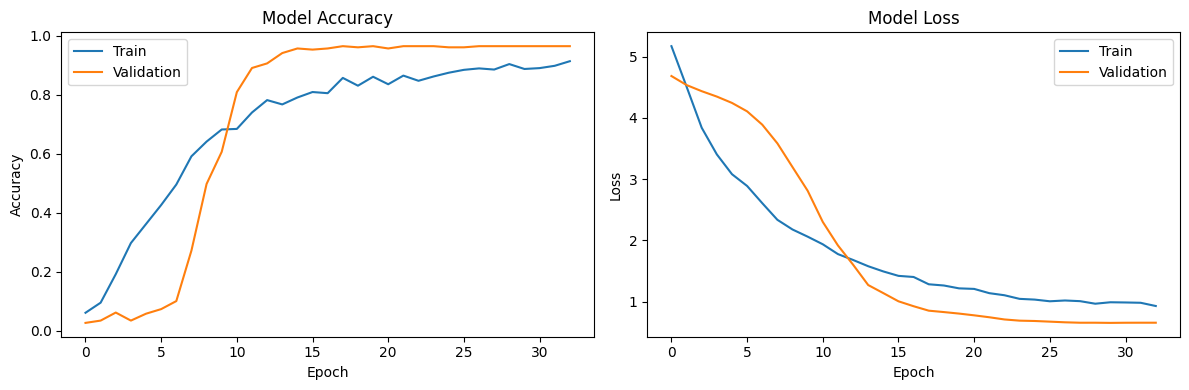

In [55]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()